In [1]:
import numpy as np
import networkx as nx
import matplotlib
from scipy.stats import multivariate_normal
% matplotlib inline

UsageError: Line magic function `%` not found.


In [13]:
1/9

0.1111111111111111

## Let us try out networkx on an example tree

We will use this tree for all the incoming computations. Especially, the tree is defined by the following variables
\begin{align}
(x_1, x_2, x_3, x_4, y_1, y_2, z_1) = (v_0, v_1, v_2, v_3, v_4, v_5, v_6)
\end{align}
$x$ designates the leaves (observed or last layer of hidden variables). These variables will be connected later to an observation model. $y$ and $z$ denotes the first order and second order of internal nodes. $v_6 = z_1$ is the root node (associated to the prior of the Gaussian random walk).

In [2]:
# let us encode the adjacency matrix 
# A_{ij} = 0 if no edge between i and j
# A_{ij} > 0 means there is an edge and denotes the duration from the parent to the child
# A_{ij} < 0 is not allowed

A = np.array([[0, 0, 0, 0, 0, 1, 0, 0], 
              [0, 0, 0, 0, 0, 1, 0, 0], 
              [0, 0, 0, 0, 0, 0, 1, 0],
              [0, 0, 0, 0, 0, 0, 1, 0],
              [0, 0, 0, 0, 0, 0, 0, 1],
              [1, 1, 0, 0, 0, 0, 0, 1],
              [0, 0, 1, 1, 0, 0, 0, 1],
              [0, 0, 0, 0, 1, 1, 1, 0]])



T = nx.from_numpy_array(A)

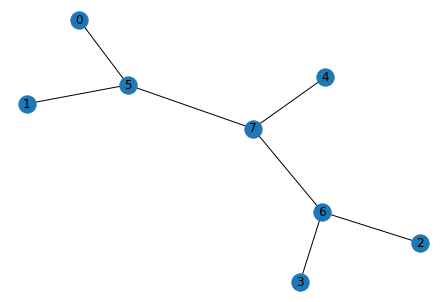

In [3]:
nx.draw(T, with_labels=True)

In order to collect the prior information while computing the posterior predictive density, we need to add a virtual node with the prior information as follow

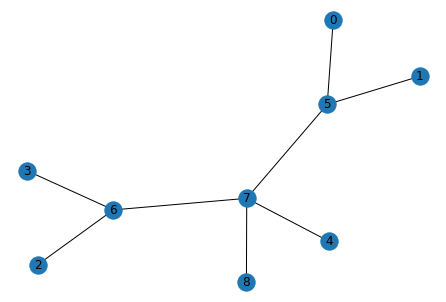

In [4]:
# add a fake node to simulate the prior
T_add = nx.Graph(T)
T_add.add_node(8)
T_add.add_edge(7, 8, weight=1)
nx.draw(T_add, with_labels=True)

In [10]:
import numpy as np

sigma = np.array([[11.,  1.],
        [ 1., 11.]])
evidence = np.array([[-2.0],
                     [3.0]])

In [13]:
1 - np.ones(2).T @ np.linalg.inv(sigma) @ np.ones(2)

0.8333333333333333

In [14]:
np.ones(2).T @ np.linalg.inv(sigma) @ (evidence)

array([0.08333333])

In [15]:
2 / 10

0.2

## 1. Exact computations via matrix inversion

For this, we need to compute the mean and covariance of the marginals. The mean will always be zero. We are therefore left with computing the covariances. For this, let us start by forming the precision matrix of the whole distribution

\begin{align}
\log p(x1, y1, x2, z1, x3, y2, x4) = \sum_{nodes} \log p(node \mid parent) \\
 = \sum_{nodes} - \frac{|| x - \pi(x)||^2}{2 \delta_{x, \pi(x)}^2} \\
  = \sum_{nodes} -\frac{1}{2} \left[ \frac{x^2}{\delta_{x, \pi(x)}^2} + \frac{\pi(x)^2}{\delta_{x, \pi(x)}^2} - 2\frac{x\pi(x)}{\delta_{x, \pi(x)}^2} \right] \\
  = \sum_{ij} -\frac{1}{2} \Sigma^{-1}_{ij} x_i x_j
\end{align}

From this we can identify the coefficients in linear time

(z1) = (x7)

(y1, y2) = (x5, x6)

(x1, x2, x3, x4)

In [5]:
parents = {1:6, 2:6, 3:7, 4:7, 5:8, 6:8, 7:8}

In [6]:
d = 2
inverse_covariance = np.zeros((8 * d, 8 * d))
for i in range(7):
    pi_ind = parents[i + 1] - 1
    print(i, pi_ind)
    inverse_covariance[i * d: (i + 1) * d, i * d: (i + 1) * d] += np.identity(d)
    inverse_covariance[pi_ind * d: (pi_ind + 1) * d, pi_ind * d: (pi_ind + 1) * d] += np.identity(d)
    inverse_covariance[pi_ind * d: (pi_ind + 1) * d, i * d: (i + 1) * d] += - np.identity(d)
    inverse_covariance[i * d: (i + 1) * d, pi_ind * d: (pi_ind + 1) * d] += - np.identity(d)
inverse_covariance[7 * d: (7 + 1) * d, 7 * d: (7 + 1) * d] += np.identity(d)

full_covariance = np.linalg.inv(inverse_covariance)

0 5
1 5
2 6
3 6
4 7
5 7
6 7


In [7]:
print("Inverse covariance")
print(inverse_covariance)
print("Full covariance")
print(full_covariance)

Inverse covariance
[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0. -1.]
 [-1.  0. -1.  0.  0.  0.  0.  0.  0.  0.  3.  0.  0.  0. -1.  0.]
 [ 0. -1.  0. -1.  0.  0.  0.  0.  0.  0.  0.  3.  0.  0.  0. -1.]
 [ 0.  0.  0.  0. -1.  0. -1.  0.  0.  0.  0.  0.  3.  0. -1.  0.]
 [ 0.  0.  0.  0.  0. -1.  0. -1.  0.  0.  0.  0.  0.  3.  0. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  0. -

## 2. Exact computations via message passing

Initialize the network with messages

In [8]:
def initialize_messages(G, d, evidence, prior_node):
    dic_nu = {}
    dic_mu = {}
    dic_log_z = {}
    for i, j in enumerate(evidence):
        dic_nu[i] = 0
        dic_log_z[i] = 0
        dic_mu[i] = j
    dic_nu[prior_node] = 0
    dic_mu[prior_node] = np.zeros(d)
    dic_log_z[prior_node] = 0
    nx.set_node_attributes(G, dic_nu, 'nu')
    nx.set_node_attributes(G, dic_mu, 'mu')
    nx.set_node_attributes(G, dic_log_z, 'log_z')

In [9]:
def initialize_visit(G, prior_node):
    dic_visited = {}
    for node in G:
        dic_visited[node] = False
    nx.set_node_attributes(G, dic_visited, 'visited')

In [10]:
def perform_message_passing(T, root_nodes, prior_nodes, include_prior):
    # print(root_nodes)
    # flag the nodes as visited
    T.nodes[root_nodes]["visited"] = True
            
    incoming_messages = []
    # get list of neighbors that are not visited yet
    for nodes in T.neighbors(root_nodes):
        if not T.nodes[nodes]["visited"] and (nodes != prior_nodes  or (nodes == prior_nodes and include_prior) ):
            perform_message_passing(T, nodes, prior_nodes, include_prior)
            incoming_messages.append(nodes)
            
    # collect and return 
    if len(incoming_messages) == 0:
        # nothing to do. This happens on the leaves
        return None
    
    "elif len(incoming_messages) == 1:
        # this happens when passing through the root
        k = incoming_messages[0]
        T.nodes[root_nodes]["nu"] = T.nodes[k]["nu"] + T[root_nodes][k]["weight"]
        T.nodes[root_nodes]["mu"] = T.nodes[k]["mu"]
        T.nodes[root_nodes]["log_z"] = 0
            
    elif len(incoming_messages) == 2:
        # let us give them arbitrary names k and l (could be left and right)
        k = incoming_messages[0]
        l = incoming_messages[1]
        
        # let us compute the updates
        k_nu_inc = T.nodes[k]["nu"] + T[root_nodes][k]["weight"]
        l_nu_inc = T.nodes[l]["nu"] + T[root_nodes][l]["weight"]
        
        T.nodes[root_nodes]["nu"] = 1. / ( 1. / k_nu_inc + 1. / l_nu_inc)
        T.nodes[root_nodes]["mu"] = T.nodes[k]["mu"] / k_nu_inc + T.nodes[l]["mu"] / l_nu_inc
        T.nodes[root_nodes]["mu"] *= T.nodes[root_nodes]["nu"]
        
        lambda_ = k_nu_inc + l_nu_inc
        T.nodes[root_nodes]["log_z"] = -0.5 * np.sum((T.nodes[k]["mu"] - T.nodes[l]["mu"]) ** 2) / lambda_
        T.nodes[root_nodes]["log_z"] -= d * 0.5 * np.log(2 * np.pi * lambda_)         

    elif len(incoming_messages) == 3:
        # This happens when performing the posterior predictive variant of the message passing
         # let us give them arbitrary names k, l and m 
        k = incoming_messages[0]
        l = incoming_messages[1]       
        m = incoming_messages[2]
        
        # let us compute the updates
        k_nu_inc = T.nodes[k]["nu"] + T[root_nodes][k]["weight"]
        l_nu_inc = T.nodes[l]["nu"] + T[root_nodes][l]["weight"]
        m_nu_inc = T.nodes[m]["nu"] + T[root_nodes][m]["weight"]
        
        T.nodes[root_nodes]["nu"] = 1. / ( 1. / k_nu_inc + 1. / l_nu_inc + 1. / m_nu_inc)
        T.nodes[root_nodes]["mu"] = T.nodes[k]["mu"] / k_nu_inc + T.nodes[l]["mu"] / l_nu_inc + T.nodes[m]["mu"] / m_nu_inc
        T.nodes[root_nodes]["mu"] *= T.nodes[root_nodes]["nu"]
        
        lambda_ = k_nu_inc * l_nu_inc + k_nu_inc * m_nu_inc + l_nu_inc * m_nu_inc
        T.nodes[root_nodes]["log_z"] = m_nu_inc * np.sum((T.nodes[k]["mu"] - T.nodes[l]["mu"]) ** 2)
        T.nodes[root_nodes]["log_z"] += l_nu_inc * np.sum((T.nodes[k]["mu"] - T.nodes[m]["mu"]) ** 2) 
        T.nodes[root_nodes]["log_z"] += k_nu_inc * np.sum((T.nodes[l]["mu"] - T.nodes[m]["mu"]) ** 2) 
        T.nodes[root_nodes]["log_z"] *= -0.5 / lambda_
        T.nodes[root_nodes]["log_z"] -= d * 0.5 * np.log(2 * np.pi * lambda_)
        
    else:
        # Here there is a problem, we might have tried to compute something wierd
        raise NotImplementedError("This should not happen (more than 3). nodes" + str(root_nodes))

In [11]:
def aggregate_messages_into_leaves_likelihood(T, root, add_prior):
    res = 0
    
    # agg Z messages
    for nodes in T.nodes():
        res += T.nodes[nodes]["log_z"]
        
    if add_prior:
        # add prior
        nu_inc = 1 + T.nodes[root]["nu"]
        res += - 0.5 * np.sum(T.nodes[root]["mu"] ** 2) / nu_inc - d * 0.5 * np.log(2 * np.pi * nu_inc)
    
    return res

### 2.a case for leaves marginals (for VI bound)

the task here is to compute $\log p(x_1, x_2, x_3, x_4)$. This can be done quickly via marginalization of the Gaussian vector

In [14]:
evidence = [np.array([1] * d),
            np.array([1] * d),
            np.array([1] * d),
            np.array([1] * d),
            np.array([1] * d)
            ]

# marginalization of covariance
leaves_covariance = full_covariance[:5 * d, :5 * d]
leaves_mean = np.array([0] * 5 * d)

# message passing: call from the root
root = 7
prior_node = 8
tree = T_add
collect_prior_node = False

initialize_visit(tree, prior_node)
initialize_messages(tree, d, evidence + [0] * 3 * d, prior_node)
perform_message_passing(tree, root, prior_node, collect_prior_node)

print("Gaussian marginalization output O(n^3d^3): ",
      multivariate_normal.logpdf(np.hstack(evidence), leaves_mean, leaves_covariance))

print("Message passing output O(nd): ", 
      aggregate_messages_into_leaves_likelihood(tree, root, add_prior=True)) 

Gaussian marginalization output O(n^3d^3):  -13.29058271370888
Message passing output O(nd):  -11.452705647299538


In [15]:
np.hstack(evidence), leaves_mean

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [16]:
full_covariance

array([[3., 0., 2., 0., 1., 0., 1., 0., 1., 0., 2., 0., 1., 0., 1., 0.],
       [0., 3., 0., 2., 0., 1., 0., 1., 0., 1., 0., 2., 0., 1., 0., 1.],
       [2., 0., 3., 0., 1., 0., 1., 0., 1., 0., 2., 0., 1., 0., 1., 0.],
       [0., 2., 0., 3., 0., 1., 0., 1., 0., 1., 0., 2., 0., 1., 0., 1.],
       [1., 0., 1., 0., 3., 0., 2., 0., 1., 0., 1., 0., 2., 0., 1., 0.],
       [0., 1., 0., 1., 0., 3., 0., 2., 0., 1., 0., 1., 0., 2., 0., 1.],
       [1., 0., 1., 0., 2., 0., 3., 0., 1., 0., 1., 0., 2., 0., 1., 0.],
       [0., 1., 0., 1., 0., 2., 0., 3., 0., 1., 0., 1., 0., 2., 0., 1.],
       [1., 0., 1., 0., 1., 0., 1., 0., 2., 0., 1., 0., 1., 0., 1., 0.],
       [0., 1., 0., 1., 0., 1., 0., 1., 0., 2., 0., 1., 0., 1., 0., 1.],
       [2., 0., 2., 0., 1., 0., 1., 0., 1., 0., 2., 0., 1., 0., 1., 0.],
       [0., 2., 0., 2., 0., 1., 0., 1., 0., 1., 0., 2., 0., 1., 0., 1.],
       [1., 0., 1., 0., 2., 0., 2., 0., 1., 0., 1., 0., 2., 0., 1., 0.],
       [0., 1., 0., 1., 0., 2., 0., 2., 0., 1., 0.,

### 2.b case for posterior predictive density

First, let us try to compute the probability of a leave $n$ given observation at all the others, for example
$$x_4 \mid x_1, x_2, x_3$$
For this, we need simply need to maginalize $x_4, y_1, y_2, z_1 \mid x_1, x_2, x_3$, itself given by the Gaussian condioning formula

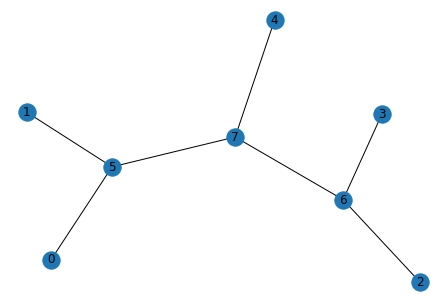

In [17]:
nx.draw(T, with_labels=True)

In [18]:
#calculate the mean and variance of x_4 | x_1, x_2, x_3
evidence = [np.array([1] * d), np.array([2] * d), np.array([1] * d)]

# Gaussian conditioning formula
cov_ii = full_covariance[3 * d:, 3 * d:]
cov_il = full_covariance[3 * d:, :3 * d]
cov_ll = full_covariance[:3 * d, :3 * d]
cov_li = full_covariance[:3 * d, 3 * d:]

internal_post_mean_transform = np.dot(cov_il, np.linalg.inv(cov_ll))
internal_post_covar = cov_ii - np.dot(np.dot(cov_il, np.linalg.inv(cov_ll)), cov_li)

# message passing: call from the leaf and collect the prior information
query_node = 3
prior_node = 7
tree = T_add
collect_prior_node = True

# perform message passing
initialize_visit(tree, prior_node)
initialize_messages(tree, d, evidence + [0] * 4 * d, prior_node)
perform_message_passing(tree, query_node, prior_node, collect_prior_node)

print("Gaussian conditioning formula O(n^3d^3): ",
      np.dot(internal_post_mean_transform, np.hstack(evidence))[0: d], internal_post_covar[0, 0])

print("Message passing output O(nd): ", 
      tree.nodes[query_node]["mu"], tree.nodes[query_node]["nu"])

Gaussian conditioning formula O(n^3d^3):  [0.84615385 0.84615385] 1.6153846153846154
Message passing output O(nd):  [0.73684211 0.73684211] 1.5789473684210527


Second, let us try to compute the probability of an internal node $n$ given observation at all the leaves, for example
$$y_1 \mid x_1, x_2, x_3, x_4$$
For this, we need simply need to maginalize $y_1, y_2, z_1 \mid x_1, x_2, x_3, x_4$, itself given by the Gaussian conditioning formula

In [19]:
#calculate the mean and variance of y_1 | x_1, x_2, x_3
evidence = [np.array([1] * d), np.array([2] * d), np.array([1] * d), np.array([1] * d)]

# Gaussian conditioning formula
cov_ii = full_covariance[4 * d:, 4 * d:]
cov_il = full_covariance[4 * d:, :4 * d]
cov_ll = full_covariance[:4 * d, :4 * d]
cov_li = full_covariance[:4 * d, 4 * d:]

internal_post_mean_transform = np.dot(cov_il, np.linalg.inv(cov_ll))
internal_post_covar = cov_ii - np.dot(np.dot(cov_il, np.linalg.inv(cov_ll)), cov_li)

# message passing: call from the leaf and collect the prior information
query_node = 4
prior_node = 7
tree = T_add
collect_prior_node = True

# perform message passing
initialize_visit(tree, prior_node)
initialize_messages(tree, d, evidence + [0] * 3 * d, prior_node)
perform_message_passing(tree, query_node, prior_node, collect_prior_node)

print("Gaussian conditioning formula O(n^3d^3): ",
      np.dot(internal_post_mean_transform, np.hstack(evidence))[0: d], internal_post_covar[0, 0])

print("Message passing output O(nd): ", 
      tree.node[query_node]["mu"], tree.node[query_node]["nu"])

Gaussian conditioning formula O(n^3d^3):  [0.71428571 0.71428571] 1.4285714285714286


AttributeError: 'Graph' object has no attribute 'node'